### Improving Language Understanding by Generative Pre-Training을 기반으로 Transformer 구조 변형하기
* input을 할 때 positional encoding과 word embedding대신 positional embedding matrix와 token embedding matrix를 사용한다.
* encoder를 제거하고 오직 디코더로만 사용하기.


In [1]:
import nltk
nltk.download('punkt')
from konlpy.tag import Okt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 데이터 수집

In [90]:
path = os.getenv("HOME")+"/aiffel/transformer_chatbot/data/ChatbotData .csv"
data = pd.read_csv(path)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 11823


In [91]:
data.head

<bound method NDFrame.head of                              Q                         A  label
0                       12시 땡!                하루가 또 가네요.      0
1                  1지망 학교 떨어졌어                 위로해 드립니다.      0
2                 3박4일 놀러가고 싶다               여행은 언제나 좋죠.      0
3              3박4일 정도 놀러가고 싶다               여행은 언제나 좋죠.      0
4                      PPL 심하네                눈살이 찌푸려지죠.      0
...                        ...                       ...    ...
11818           훔쳐보는 것도 눈치 보임.        티가 나니까 눈치가 보이는 거죠!      2
11819           훔쳐보는 것도 눈치 보임.             훔쳐보는 거 티나나봐요.      2
11820              흑기사 해주는 짝남.                    설렜겠어요.      2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?  잘 헤어질 수 있는 사이 여부인 거 같아요.      2
11822               힘들어서 결혼할까봐        도피성 결혼은 하지 않길 바라요.      2

[11823 rows x 3 columns]>

## 데이터 전처리

#### 중복된 Question data가 있는지 확인

In [92]:
print('Q 열에서 중복을 배제한 유일한 샘플의 수 :', data['Q'].nunique())
print('A 열에서 중복을 배제한 유일한 샘플의 수 :', data['A'].nunique())

Q 열에서 중복을 배제한 유일한 샘플의 수 : 11662
A 열에서 중복을 배제한 유일한 샘플의 수 : 7779


In [93]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Q'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 11662


#### 결측치가 있는지 확인

In [94]:
print(data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


결측치가 없습니다.

#### 텍스트 정규화와 불용어 제거

In [7]:
# 챗봇에서는 불용어를 제거하게 되면 대화의 자연스러움이 없어질 수 있기 때문에 
# 불용어 제거는 하지 않는 쪽으로 가도록 하겠습니다.
#불용어
stopwords = ['저','그','의', '가', '이', '은', '는', '을', '를', '에', '와', '과','도','로', '하다', '다','이다', '하다', '되다']

In [95]:
def preprocess_sentence(sentence, remove_stopwords=True):
    # 단어와 구두점 사이의 거리를 만들기
    sentence = re.sub(r"([?.!])", r" \1", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 특수문자 제거 (필요 없는 특수문자만 제거)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z?.!\s]", "", sentence)
    
    # 숫자와 문자 사이에 공백 추가
    sentence = re.sub(r'(\d)([a-zA-Z가-힣])', r'\1 \2', sentence)
    sentence = re.sub(r'([a-zA-Z가-힣])(\d)', r'\1 \2', sentence)
    
    return sentence


In [96]:
temp_Q = '오늘 6시에 행복한 일이 있을까?'
temp_A = '있을 것 같아!'

print("Question: ", preprocess_sentence(temp_Q))
print("Answer:", preprocess_sentence(temp_A, False))

Question:  오늘 6 시에 행복한 일이 있을까 ?
Answer: 있을 것 같아 !


In [97]:
data['Q'] = data['Q'].map(lambda x: preprocess_sentence(x, True))

In [98]:
data['A'] = data['A'].map(lambda x: preprocess_sentence(x, True))

In [71]:
print(data[:5])

                    Q             A  label
0            12 시 땡 !   하루가 또 가네요 .      0
1        1 지망 학교 떨어졌어    위로해 드립니다 .      0
2     3 박 4 일 놀러가고 싶다  여행은 언제나 좋죠 .      0
3  3 박 4 일 정도 놀러가고 싶다  여행은 언제나 좋죠 .      0
4             PPL 심하네   눈살이 찌푸려지죠 .      0


#### 사전만들기

In [74]:
# Make Vocabulary - using subwordTextEncoder
def makeVocabulary(data):
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data, target_vocab_size=2**13)
    
    return tokenizer

In [77]:
tokenizer = makeVocabulary(data['Q']+ data['A'] )
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN, delimiter = [tokenizer.vocab_size], [tokenizer.vocab_size + 1], [tokenizer.vocab_size +2]

In [78]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print('delimiter의 번호 :', [tokenizer.vocab_size + 2])

START_TOKEN의 번호 : [8281]
END_TOKEN의 번호 : [8282]
delimiter의 번호 : [8283]


In [79]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 3
print(VOCAB_SIZE)

8284


#### 각 단어를 고유한 정수로 인코드 & 패딩

Q의 최소 길이 : 1
Q의 최대 길이 : 16
Q의 평균 길이 : 3.97616189332876
A의 최소 길이 : 1
A의 최대 길이 : 24
A의 평균 길이 : 4.719945120905505


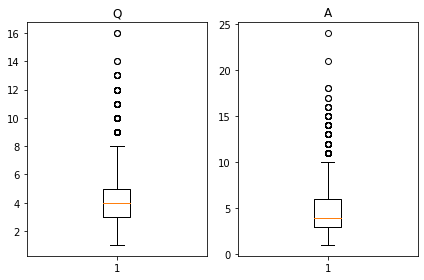

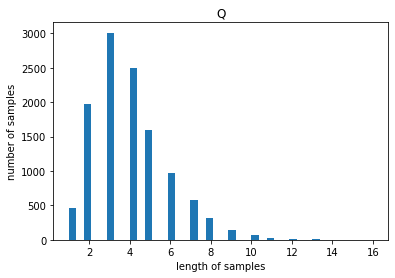

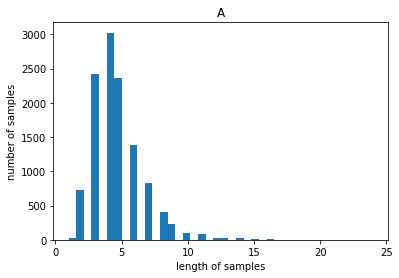

In [101]:
# 길이 분포 출력
import matplotlib.pyplot as plt

Q_len = [len(s.split()) for s in data['Q']]
A_len = [len(s.split()) for s in data['A']]

print('Q의 최소 길이 : {}'.format(np.min(Q_len)))
print('Q의 최대 길이 : {}'.format(np.max(Q_len)))
print('Q의 평균 길이 : {}'.format(np.mean(Q_len)))
print('A의 최소 길이 : {}'.format(np.min(A_len)))
print('A의 최대 길이 : {}'.format(np.max(A_len)))
print('A의 평균 길이 : {}'.format(np.mean(A_len)))

plt.subplot(1,2,1)
plt.boxplot(Q_len)
plt.title('Q')
plt.subplot(1,2,2)
plt.boxplot(A_len)
plt.title('A')
plt.tight_layout()
plt.show()

plt.title('Q')
plt.hist(Q_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('A')
plt.hist(A_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [102]:
Q_MAX_LENGTH = 14
A_MAX_LENGTH = 20
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 12 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= Q_MAX_LENGTH and len(sentence2) <= A_MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  # 최대 길이 12으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    return tokenized_inputs, tokenized_outputs

In [103]:
print(len(data['Q']))
print(len(data['A']))

11662
11662


In [104]:
Q, A = tokenize_and_filter(data['Q'], data['A'])
print(Q[:5])
print(A[:5])
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(Q)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(A)))

[[8281 8022 1228 3039   38 8282    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [8281  164   50 1023 8057  984 1898 8282    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [8281  189 2989  458   84 3617   78 8282    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [8281  189 2989  458   84 1383 3617   78 8282    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [8281 8105 8105 8101 8057 4174 8282    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
[[8281 3805   73 8013    1 8282    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [8281 1827 5507    1 8282    0    0    0    0    0    0 

In [111]:
print(len(Q))
print(Q[0])
print(A[1])

11471
[8281 8022 1228 3039   38 8282    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[8281 1827 5507    1 8282    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


#### Decoder만을 사용할 경우 Question과 Answer를 사이에 # delimiter를 넣고 하나로 묶어야한다.

In [114]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000
QA = []
for q, a in zip(Q, A[:,:-1]):
    np.append(q, delimiter[0])
    k = np.concatenate((q,a))
    QA.append(k)

QA = np.array(QA)
# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        # delimiter 의 값을 사이에 넣어서 이어야함
        'inputs1': QA
    },
    {
        'outputs': A[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## 모델 구성

### Scaled Dot Product Attention (유사도를 구하기)

In [22]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

  # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


### Multi-Head Attention (Encoder-Decoder Attention)

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### Transformer Block Code

In [24]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, units, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training, mask):
        attn_output = self.mha({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': mask
      })
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

### Padding Masking Code
 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있음

In [25]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### Look Ahead Masking

In [26]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### Decoder Code

In [67]:
def decoder_layer(units, d_model, num_heads, dropout = 0.1, name="decoder_layer"):
    
    inputs1 = tf.keras.Input(shape=(None,d_model), name = 'inputs1')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

# 첫 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="masked_attention1")(inputs={
          'query': inputs1,
          'key': inputs1,
          'value': inputs1,
          'mask': look_ahead_mask
      })
    attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1)
    attention1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention1+inputs1)
    

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)


    
    return tf.keras.Model(inputs = [inputs1, look_ahead_mask], outputs = outputs)



In [68]:
def transformer_only_decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            max_len,
            name='decoder'):
    
    inputs1 = tf.keras.Input(shape=(None,), name = 'inputs1')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    
    # Token Embeddings:
    token_embeddings1 = tf.keras.layers.Embedding(vocab_size, d_model)(inputs1)
    
    #Positional Embeddings:
    position1 = tf.range(start = 0, limit = max_len, delta = 1)
    position_embeddings1 = tf.keras.layers.Embedding(max_len,d_model)(position1)
    
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    x = tf.keras.layers.Dropout(rate=dropout)(x1)
    
    for _ in range(num_layers):
        x = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout
    )(inputs=[x, look_ahead_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, activation = 'softmax', name="outputs")(x)
    
    return tf.keras.Model(inputs=[inputs1], outputs=outputs)
    

##### Transformer 모델 Summary

In [69]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 #2 # 인코더와 디코더의 층의 개수
D_MODEL = 512#256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 2048 #512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer_only_decoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_len = MAX_LENGTH)

model.summary()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 1, None, None), dtype=tf.float32, name='look_ahead_mask'), name='look_ahead_mask', description="created by layer 'look_ahead_mask'") at layer "model". The following previous layers were accessed without issue: ['embedding_2', 'tf.__operators__.add_1', 'dropout']

#### 손실함수

In [51]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### 커스텀 된 학습률 (Learning rate)

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### 학습률 스케줄링 계획을 시각화하기

Text(0.5, 0, 'Train Step')

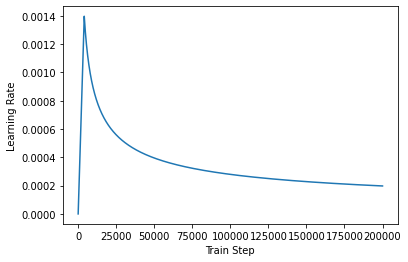

In [53]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 모델 컴파일링

In [54]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [55]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:182 assert_input_compatibility
        raise ValueError('Missing data for input "%s". '

    ValueError: Missing data for input "look_ahead_mask". You passed a data dictionary with keys ['inputs', 'dec_inputs']. Expected the following keys: ['inputs', 'look_ahead_mask', 'padding_mask']


## 모델 평가

### decoder inference 

In [ ]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    print(sentence)
  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        print(len(predictions[0,0]))
        predictions = predictions[:, -1:, :]
        print(len(predictions[0,0]))
    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        predictions.remove(tf.argmax(predictions,axis = -1))
        print(predicted_id)
    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    return tf.squeeze(output_sequence, axis=0)

### 챗봇의 대답을 얻는 함수

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

Max_length: 12, Epoch: 10

아쉬운점: 모델을 바꾸는 것에만 집중하다가 나중에서야 데이터 전처리에서 모델의 입력 형태에 맞게 처리해야한다는 것을 깨달았다. 너무 늦게 깨달아버려서 결국 전혀 완성하지도 못 했다.
